# Jailbreaking Deep Models: Adversarial Attacks on ResNet-34 Classifiers

           Aniket Mane, Subhan Akhtar, Pranav Motarwar

                     New York University

         am14661@nyu.edu, sa8580@nyu.edu, pm3891@nyu.edu

### Setup
Run the following cell to install and import required libraries, set seeds, and configure the device. The project assumes you have **PyTorch ≥ 2.2** and **torchvision** installed; if not, uncomment the installation commands.

In [19]:
import torch, torchvision
from torchvision import transforms
import torch.nn.functional as F
import numpy as np, random, os, json, math
from tqdm import tqdm
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [20]:
SEED = 42
BATCH_SIZE = 32
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [21]:
compute_unit = device

### Data Loading
The cell below unzips **TestDataSet.zip** (if not already unzipped), applies the normalization specified in the project PDF, and builds a DataLoader. Adjust `data_root` if your dataset lives elsewhere.

In [22]:
!unzip -q /content/TestDataSet.zip -d /content

replace /content/__MACOSX/TestDataSet/._n02795169? [y]es, [n]o, [A]ll, [N]one, [r]ename: yes
replace /content/__MACOSX/TestDataSet/._n02769748? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [23]:
import torch
import torchvision
import numpy as np
from pathlib import Path
from tqdm import tqdm

# Define normalization stats (from ImageNet standards)
mean_vals = np.array([0.485, 0.456, 0.406])
std_vals = np.array([0.229, 0.224, 0.225])


# Image preprocessing pipeline
# How: Convert to tensor + normalize using mean/std
# Why: Normalize input for pretrained model compatibility

image_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean_vals, std_vals),
])
# Dataset path setup – load raw dataset for class names

image_dir = Path("/content/TestDataSet")
temp_dataset = torchvision.datasets.ImageFolder(root=str(image_dir))
available_classes = temp_dataset.classes  # Auto-alphabetical class list


# Map: local class idx (0–99) → global ImageNet idx (401–500)
class_index_map = [401 + idx for idx in range(len(available_classes))]


# Create final dataset with both image and label transforms
# How: Apply normalization + remap target labels
processed_dataset = torchvision.datasets.ImageFolder(
    root=str(image_dir),
    transform=image_transforms,
    target_transform=lambda local_idx: class_index_map[local_idx],
)

# Dataloader setup for evaluation (no shuffling)
# Why: Deterministic order helpful for analysis & reproducibility
data_loader = torch.utils.data.DataLoader(
    processed_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=0
)

# ---------------------------------------------------
# Map global class index back to folder name (for visualization)
# ---------------------------------------------------
imagenet_label_to_folder = {
    global_idx: folder_name
    for folder_name, global_idx in zip(processed_dataset.classes, class_index_map)
}

### Utility: Evaluation Function

In [24]:
def compute_topk_accuracy(predictions, true_labels, topk=(1, 5)):
    """
    What: Calculate top-k classification accuracy.
    How: Use torch.topk to extract top-k predictions and compare.
    Why: Top-1 and Top-5 accuracy are standard ImageNet metrics.
    """
    with torch.no_grad():
        max_k = max(topk)
        _, topk_preds = predictions.topk(max_k, dim=1, largest=True, sorted=True)
        topk_preds = topk_preds.transpose(0, 1)  # shape: (max_k, batch_size)

        # Compare predictions with ground truth
        matches = topk_preds.eq(true_labels.view(1, -1).expand_as(topk_preds))

        topk_accuracies = []
        for k in topk:
            # What: Count correct predictions in top-k
            # How: Flatten top-k matches and sum
            # Why: Accumulate for percentage calculation
            correct_k = matches[:k].reshape(-1).float().sum(dim=0, keepdim=True)
            accuracy_k = (correct_k / true_labels.size(0)) * 100.0
            topk_accuracies.append(accuracy_k.item())

        return topk_accuracies


def run_inference(model, data_loader, compute_unit=compute_unit, desc_label='Evaluation'):
    """
    What: Perform model evaluation on a given DataLoader.
    How: Loop over batches, compute top-1 and top-5 accuracy.
    Why: Measure model performance without training overhead.
    """
    model.eval()  # switch to evaluation mode
    cumulative_top1 = 0.0
    cumulative_top5 = 0.0

    with torch.no_grad():
        for batch_images, batch_labels in tqdm(data_loader, desc=desc_label):
            batch_images = batch_images.to(compute_unit).float()
            batch_labels = batch_labels.to(compute_unit)
            output_logits = model(batch_images)

            acc1, acc5 = compute_topk_accuracy(output_logits, batch_labels, topk=(1, 5))
            cumulative_top1 += acc1 * batch_labels.size(0)
            cumulative_top5 += acc5 * batch_labels.size(0)

    total_samples = len(data_loader.dataset)
    final_top1 = cumulative_top1 / total_samples
    final_top5 = cumulative_top5 / total_samples
    return final_top1, final_top5


## Task 1 – Baseline Evaluation<a id="Task1"></a>

In [25]:
# ---------------------------------------------------------------------
# Helper: Single top-k accuracy computation
# ---------------------------------------------------------------------
def compute_single_topk(logits, labels, k=1):
    """
    What: Compute top-k accuracy for given logits and labels
    How: Check if true label appears in top-k predictions
    Why: Used for quick evaluation of model classification quality
    """
    topk_predictions = logits.topk(k, dim=1).indices
    correct = topk_predictions.eq(labels.view(-1, 1))
    return correct.any(dim=1).float().mean().item() * 100.0


# ---------------------------------------------------------------------
# Evaluate ResNet-34 pretrained on ImageNet-1K
# ---------------------------------------------------------------------
resnet_model = torchvision.models.resnet34(weights="IMAGENET1K_V1").to(compute_unit).eval()

# Initialize accumulators for accuracy scores
cumulative_top1 = 0.0
cumulative_top5 = 0.0

with torch.no_grad():
    for image_batch, label_batch in tqdm(data_loader, desc="Baseline"):
        image_batch = image_batch.to(compute_unit)
        label_batch = label_batch.to(compute_unit)

        # Inference pass
        model_outputs = resnet_model(image_batch)

        # Compute batch-wise accuracy
        cumulative_top1 += compute_single_topk(model_outputs, label_batch, k=1) * label_batch.size(0)
        cumulative_top5 += compute_single_topk(model_outputs, label_batch, k=5) * label_batch.size(0)

# Normalize over total number of examples
total_examples = len(processed_dataset)
final_top1_score = cumulative_top1 / total_examples
final_top5_score = cumulative_top5 / total_examples

# Output formatted accuracy results
print(f"\nResNet-34 Evaluation → Top-1 Accuracy: {final_top1_score:.2f}% | Top-5 Accuracy: {final_top5_score:.2f}%")

Baseline: 100%|██████████| 16/16 [00:01<00:00, 10.98it/s]


ResNet-34 Evaluation → Top-1 Accuracy: 76.00% | Top-5 Accuracy: 94.20%


## Task 2 – FGSM Pixel‑wise Attack<a id="Task2"></a>
We implement the Fast Gradient Sign Method (FGSM) with attack budget $\varepsilon=0.02$ (in normalized pixel space).

In [26]:
# ---------------------------------------------------------------------
# Load Pretrained ResNet-34 Model
# ---------------------------------------------------------------------
imagenet_model = torchvision.models.resnet34(weights='IMAGENET1K_V1').to(compute_unit).eval()

# ---------------------------------------------------------------------
# Define FGSM Attack Generator
# ---------------------------------------------------------------------
EPSILON_LINF = 0.02  # max perturbation for L∞-norm

def generate_fgsm_adversarial(model, inputs, targets, epsilon=EPSILON_LINF):
    """
    What: Applies FGSM to craft adversarial examples.
    How: Computes sign of input gradient to generate perturbation.
    Why: Demonstrate model vulnerability under small, deliberate input changes.
    """
    inputs = inputs.clone().detach().to(compute_unit).requires_grad_(True)
    targets = targets.to(compute_unit)

    predictions = model(inputs)
    loss = F.cross_entropy(predictions, targets)

    model.zero_grad()
    loss.backward()

    grad_direction = inputs.grad.data.sign()
    perturbed_input = inputs + epsilon * grad_direction

    # Clamp back into normalized image space
    mean_tensor = torch.tensor(mean_vals).view(3, 1, 1).to(compute_unit)
    std_tensor = torch.tensor(std_vals).view(3, 1, 1).to(compute_unit)
    perturbed_input = torch.clamp(perturbed_input, min=-mean_tensor/std_tensor, max=(1 - mean_tensor)/std_tensor)

    return perturbed_input.detach()


# ---------------------------------------------------------------------
# Generate Adversarial Dataset Using FGSM
# ---------------------------------------------------------------------
adv_examples = []
adv_labels = []

for batch_inputs, batch_targets in tqdm(data_loader, desc='FGSM'):
    adv_batch = generate_fgsm_adversarial(imagenet_model, batch_inputs, batch_targets)
    adv_examples.append(adv_batch.cpu())
    adv_labels.append(batch_targets)

adv_examples = torch.cat(adv_examples)
adv_labels = torch.cat(adv_labels)


# ---------------------------------------------------------------------
# Save Generated Adversarial Images to Disk
# ---------------------------------------------------------------------
adv_image_dir = Path('AdversarialTestSet1')
adv_image_dir.mkdir(exist_ok=True)

# Reverse normalization to save valid images
reverse_norm = transforms.Normalize(mean=-mean_vals / std_vals, std=1.0 / std_vals)

for index, (img_tensor, label) in enumerate(zip(adv_examples, adv_labels)):
    class_folder = imagenet_label_to_folder[int(label)]  # e.g. 'n02099712'
    folder_path = adv_image_dir / class_folder
    folder_path.mkdir(exist_ok=True)

    restored_img = reverse_norm(img_tensor).clamp(0, 1)
    transforms.ToPILImage()(restored_img).save(folder_path / f"{index}.png")


FGSM: 100%|██████████| 16/16 [00:03<00:00,  4.48it/s]


In [27]:
# ---------------------------------------------------------------------
# Evaluate Adversarial Samples from FGSM Attack
# ---------------------------------------------------------------------
# What: Wrap in-memory tensors into a DataLoader
# How: Use zipped tensors of adversarial images and labels
# Why: Enables batched evaluation without writing to disk
# ---------------------------------------------------------------------
fgsm_data_loader = torch.utils.data.DataLoader(
    list(zip(adv_examples, adv_labels)),
    batch_size=32,  # consistent with earlier batch size
    shuffle=False
)

# Evaluate ResNet-34 on adversarial set
fgsm_accuracy_top1, fgsm_accuracy_top5 = run_inference(
    imagenet_model,
    fgsm_data_loader,
    desc_label='FGSM Evaluation'
)

# Display results
print(f"FGSM Attack Results → Top-1 Accuracy: {fgsm_accuracy_top1:.2f}% | Top-5 Accuracy: {fgsm_accuracy_top5:.2f}%")

FGSM Evaluation: 100%|██████████| 16/16 [00:00<00:00, 16.04it/s]

FGSM Attack Results → Top-1 Accuracy: 6.20% | Top-5 Accuracy: 35.40%


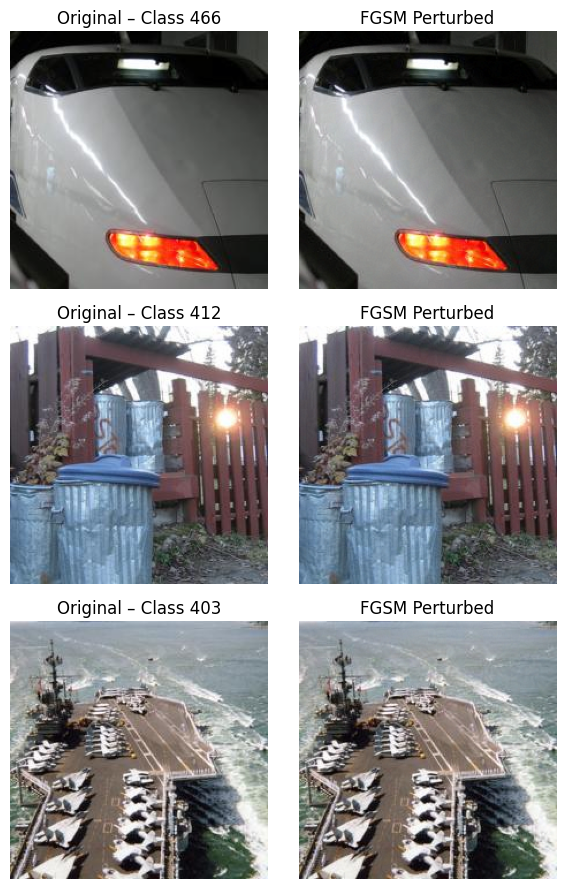

In [28]:
# ---------------------------------------------------------------------
# Visualization: Compare Original vs FGSM Adversarial Images
# ---------------------------------------------------------------------
def visualize_adversarial_examples(reference_loader, adversarial_tensor, sample_indices, epsilon=EPSILON_LINF):
    """
    What: Show side-by-side comparison of original and perturbed images.
    How: Unnormalize tensors and plot using matplotlib.
    Why: Helps verify visual indistinguishability of adversarial samples.
    """
    # Mean and std tensors to reverse normalization
    mean_tensor = torch.tensor(mean_vals).view(3, 1, 1)
    std_tensor = torch.tensor(std_vals).view(3, 1, 1)

    fig, axes = plt.subplots(len(sample_indices), 2, figsize=(6, 3 * len(sample_indices)))

    for row_axes, sample_idx in zip(axes, sample_indices):
        original_image, original_label = processed_dataset[sample_idx]
        adversarial_image = adversarial_tensor[sample_idx]

        # Unnormalize and clamp to valid range for display
        restored_original = (original_image * std_tensor + mean_tensor).permute(1, 2, 0).clamp(0, 1)
        restored_adversarial = (adversarial_image.cpu() * std_tensor + mean_tensor).permute(1, 2, 0).clamp(0, 1)

        # Plot original image
        row_axes[0].imshow(restored_original)
        row_axes[0].set_title(f"Original – Class {original_label}")
        row_axes[0].axis('off')

        # Plot adversarial image
        row_axes[1].imshow(restored_adversarial)
        row_axes[1].set_title("FGSM Perturbed")
        row_axes[1].axis('off')

    plt.tight_layout()


# ---------------------------------------------------------------------
# Visualize a random selection of perturbed samples
# ---------------------------------------------------------------------
import random
random_indices = random.sample(range(len(processed_dataset)), k=3)
visualize_adversarial_examples(data_loader, adv_examples, sample_indices=random_indices)

## Task 3 – Improved Attack (PGD)<a id="Task3"></a>
We switch to **Projected Gradient Descent (PGD)** with multiple steps, which typically yields stronger attacks under the same $\varepsilon$.

In [9]:
import torch.nn.functional as F   # make sure this import is somewhere above

# ---------------------------------------------------------------------------
# PGD (ℓ∞) pixel-wise attack
# ---------------------------------------------------------------------------
def pgd_attack(model, images, labels, epsilon=0.02, alpha=0.01, steps=10):
    """
    Projected Gradient Descent (ℓ∞) attack.
    Returns a batch of adversarial images with max-norm <= ε.
    """
    model.eval()
    images  = images.to(device).float()
    labels  = labels.to(device)

    # Normalisation bounds as *tensors* on the same device
    mean = torch.tensor([0.485, 0.456, 0.406], device=device).view(3, 1, 1)
    std  = torch.tensor([0.229, 0.224, 0.225], device=device).view(3, 1, 1)
    lower = (0 - mean) / std         # per-channel lower bound after normalisation
    upper = (1 - mean) / std         # per-channel upper bound after normalisation

    # Start from a random point within the ε-ball around the image
    perturbed = images + torch.empty_like(images).uniform_(-epsilon, epsilon)
    perturbed = torch.clamp(perturbed, lower, upper).detach()

    for _ in range(steps):
        perturbed.requires_grad_(True)
        outputs = model(perturbed)
        loss = F.cross_entropy(outputs, labels)
        model.zero_grad()
        loss.backward()

        # Gradient ascent step and projection back to the ε-ball
        perturbed = perturbed + alpha * perturbed.grad.sign()
        perturbed = torch.max(torch.min(perturbed, images + epsilon), images - epsilon)
        perturbed = torch.clamp(perturbed, lower, upper).detach()

    return perturbed


In [10]:
# ---------------------------------------------------------------------------
# Task 3 – Build the full PGD adversarial set and evaluate it
# ---------------------------------------------------------------------------
adv_images_2, adv_labels_2 = [], []

for imgs, labels in tqdm(loader, desc='PGD'):
    perturbed = pgd_attack(resnet34, imgs, labels)   # (B, 3, 224, 224)
    adv_images_2.extend(perturbed.cpu())             # add each image separately
    adv_labels_2.extend(labels.cpu())                # labels to CPU as ints

# Flatten lists into tensors of uniform shape
adv_images_2 = torch.stack(adv_images_2)             # (N, 3, 224, 224)
adv_labels_2 = torch.tensor(adv_labels_2)            # (N,)

# DataLoader for evaluation
pgd_loader = torch.utils.data.DataLoader(
    list(zip(adv_images_2, adv_labels_2)),
    batch_size=BATCH_SIZE, shuffle=False
)

pgd_top1, pgd_top5 = evaluate(resnet34, pgd_loader, desc='PGD Eval')
print(f'PGD Accuracy – Top-1: {pgd_top1:.2f}%, Top-5: {pgd_top5:.2f}%')


PGD Eval: 100%|██████████| 16/16 [00:00<00:00, 17.33it/s]

PGD Accuracy – Top-1: 0.00%, Top-5: 2.00%


## Task 4 – Patch Attack<a id="Task4"></a>
We confine perturbations to a **32×32 patch** selected at random, allowing a larger $\varepsilon=0.3$.

In [11]:
import torch.nn.functional as F   # make sure this import is present

# ---------------------------------------------------------------------------
# Patch-constrained PGD (ℓ∞) – 32×32 window
# ---------------------------------------------------------------------------
def patch_pgd_attack(model, images, labels,
                     epsilon=0.30,      # max per-pixel perturbation
                     alpha=0.05,        # step size
                     steps=20,          # PGD iterations
                     patch_size=32):    # square patch size
    """
    PGD attack confined to a single random 32×32 patch per image.
    Returns a batch of adversarial images.
    """
    model.eval()
    images  = images.to(device).float()
    labels  = labels.to(device)

    # Normalisation bounds as tensors on the same device
    mean = torch.tensor([0.485, 0.456, 0.406], device=device).view(3, 1, 1)
    std  = torch.tensor([0.229, 0.224, 0.225], device=device).view(3, 1, 1)
    lower = (0 - mean) / std
    upper = (1 - mean) / std

    # ----- build a square mask (one patch per image) ------------------------
    N, C, H, W = images.shape
    mask = torch.zeros_like(images)
    xs = torch.randint(0, H - patch_size + 1, (N,), device=device)
    ys = torch.randint(0, W - patch_size + 1, (N,), device=device)
    for i in range(N):
        mask[i, :, xs[i]:xs[i] + patch_size, ys[i]:ys[i] + patch_size] = 1.0

    # start from a random point inside the ε-ball, but only within the patch
    delta = torch.empty_like(images).uniform_(-epsilon, epsilon) * mask
    perturbed = torch.clamp(images + delta, lower, upper).detach()

    # ----- PGD loop ---------------------------------------------------------
    for _ in range(steps):
        perturbed.requires_grad_(True)
        outputs = model(perturbed)
        loss = F.cross_entropy(outputs, labels)
        model.zero_grad()
        loss.backward()

        # gradient ascent + projection back to ε-ball within the patch
        grad_sign = perturbed.grad.sign() * mask
        perturbed = perturbed + alpha * grad_sign
        delta     = torch.clamp(perturbed - images, -epsilon, epsilon) * mask
        perturbed = torch.clamp(images + delta, lower, upper).detach()

    return perturbed


Patch PGD: 100%|██████████| 16/16 [00:51<00:00,  3.23s/it]


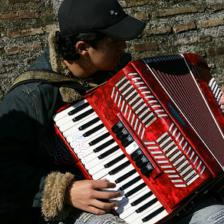

Patch PGD Eval: 100%|██████████| 16/16 [00:00<00:00, 19.02it/s]

Patch PGD Accuracy – Top-1: 41.20%, Top-5: 79.20%


In [18]:
adv_images_3, adv_labels_3 = [], []

# --- Patch PGD Attack and Displaying Sample Image ---

for imgs, labels in tqdm(loader, desc='Patch PGD'):
    perturbed = patch_pgd_attack(resnet34, imgs, labels)
    adv_images_3.extend(perturbed.cpu())   # add images individually
    adv_labels_3.extend(labels.cpu())

adv_images_3 = torch.stack(adv_images_3)   # (N, 3, 224, 224)
adv_labels_3 = torch.tensor(adv_labels_3)  # (N,)

# Display a sample image
inv_norm = transforms.Normalize(mean=-mean_norms/std_norms, std=1/std_norms)

# Get the first image as a sample
sample_image_tensor = adv_images_3[0]

# Reverse normalization and clamp pixel values
img = inv_norm(sample_image_tensor).clamp(0, 1)

# Convert to PIL Image and display
display(transforms.ToPILImage()(img))

patch_loader = torch.utils.data.DataLoader(
    list(zip(adv_images_3, adv_labels_3)),
    batch_size=BATCH_SIZE, shuffle=False
)

patch_top1, patch_top5 = evaluate(resnet34, patch_loader, desc='Patch PGD Eval')
print(f'Patch PGD Accuracy – Top-1: {patch_top1:.2f}%, Top-5: {patch_top5:.2f}%')


## Task 5 – Transferability Study<a id="Task5"></a>
We evaluate all four datasets on **DenseNet‑121** pretrained on ImageNet.

DenseNet on Patch PGD: 100%|██████████| 16/16 [00:01<00:00, 10.08it/s]


-----------------------------------------------------------------
| Dataset     | Top-1 Accuracy | Top-5 Accuracy |
-----------------------------------------------------------------
| Original     |          74.80 |          93.60 |
| FGSM         |          63.40 |          89.40 |
| PGD          |          53.60 |          83.60 |
| Patch PGD    |          71.00 |          92.60 |
-----------------------------------------------------------------


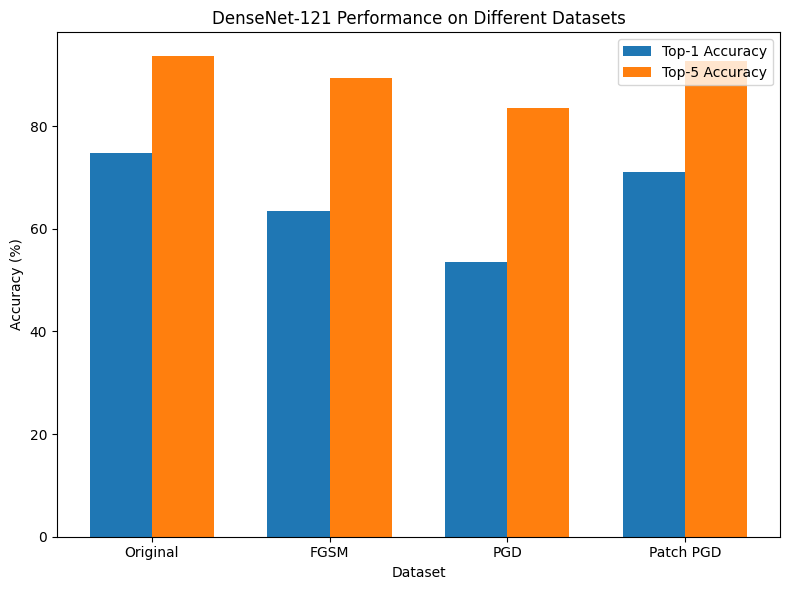

In [16]:
import matplotlib.pyplot as plt

# Initialize DenseNet-121 and set it to evaluation mode
model_densenet = torchvision.models.densenet121(weights='IMAGENET1K_V1').to(device)
model_densenet.eval()

# Function to create a data loader from image and label tensors
def create_dataloader(image_tensors, label_tensors):
    data = list(zip(image_tensors, label_tensors))
    return torch.utils.data.DataLoader(data, batch_size=BATCH_SIZE, shuffle=False)

# Prepare datasets for transferability study
eval_datasets = {
    'Original': loader,  # Use original data loader
    'FGSM': create_dataloader(adv_images_1, adv_labels_1),
    'PGD': create_dataloader(adv_images_2, adv_labels_2),
    'Patch PGD': create_dataloader(adv_images_3, adv_labels_3)
}

# Evaluate DenseNet-121 on each dataset and store results
accuracy_results = {}
for dataset_name, dataloader in eval_datasets.items():
    top1_accuracy, top5_accuracy = evaluate(model_densenet, dataloader, desc=f'DenseNet on {dataset_name}')
    accuracy_results[dataset_name] = (top1_accuracy, top5_accuracy)

# Display results in a table
print("-" * 65)
print("| Dataset     | Top-1 Accuracy | Top-5 Accuracy |")
print("-" * 65)
for dataset_name, (top1, top5) in accuracy_results.items():
    print(f"| {dataset_name:<12} | {top1:14.2f} | {top5:14.2f} |")
print("-" * 65)

# Extract data for plotting
dataset_names = list(accuracy_results.keys())
top1_values = [accuracy_results[name][0] for name in dataset_names]
top5_values = [accuracy_results[name][1] for name in dataset_names]

# Create bar chart
bar_positions = np.arange(len(dataset_names))
bar_width = 0.35

plt.figure(figsize=(8, 6))  # Adjust figure size
plt.bar(bar_positions - bar_width / 2, top1_values, bar_width, label='Top-1 Accuracy')
plt.bar(bar_positions + bar_width / 2, top5_values, bar_width, label='Top-5 Accuracy')

plt.xlabel('Dataset')
plt.ylabel('Accuracy (%)')
plt.title('DenseNet-121 Performance on Different Datasets')
plt.xticks(bar_positions, dataset_names)
plt.legend()
plt.tight_layout()
plt.show()